# Projet d'informatique : Accélération du calcul de la désorientation cristalline

**Encadrant :** Henry Proudhon, Centre des Matériaux


**Participants :** Estéban Daude, Valentin Deumier, Sioban Nieradzik-Kozic, Nathan Rapin

Ce document présente de manière synthétique le sujet de notre projet d'informatique. Nous en verrons rapidement le contexte, puis nous chercherons les outils mathématiques appropriés à l'accélartion du calcul de la désorientation cristalline, que nous implémenterons enfin au sein de la librairie pymicro.

Le diaporama diffusé au cours de notre soutenance orale du 11/07/2024 est également disponible dans le présent repo github. Il sera utile de le visionner en parallèle de la lecture de ce document afin d'y retrouver certaines figures, les références étant indiqués entre crochets par numéro de diapositive.

## Introduction

Nous avons travaillé sur la libraire Pymicro, développée au CMAT sous licance libre, permettant d'analyser a microstructure des matériaux, notamment en traitant des données de microscopie mesurées avec la technique EBSD.

Ce projet vise à rendre efficace le calcul de la désorientation cristalline entre 2 points matériels, un calcul qui est effectué massievement à chaque analyse.

### **Orientation et désorientation cristalline**

Un **cristal** est un solide dont la structure atomique est ordonnée et périodique dans les trois directions de l'espace. Une maille est un parallélépipède dont les sommets sont des nœuds.

Il n’est pas rare d’élaborer des matériaux dans lesquels l’orientation cristalline est constante d’un bout à l’autre de la pièce. Les aubes monocristallines de turbine de moteur d’avion est un exemple de structure mécanique.

Cela dit, des considérations thermodynamiques et cinétiques font que les matériaux sont généralement constitués de plusieurs cristaux (ou grains) : ils sont polycristallins. Ces grains ayant chacun leur propre orientation cristallographique. [diapositive 5/36]

L’**orientation** d’un cristal est sa position par rapport au référentiel de l’échantillon ou du laboratoire. La **désorientation** entre deux cristaux est leur orientation relative. Ainsi, une désorientation est la transformation de repère d’un point à un autre du polycristal. [diapositive 6/36]

Pour décrire une orientation cristalline, on définit une relation matricielle qui lie le repère du cristal à celui de l’échantillon par une matrice de rotation g. Cette matrice peut être exprimée à partir de différents paramètres comme les indices de Miller. Nous verrons d’autres façons qui permettent de représenter l’orientation d’un cristal. Certaines représentations sont bien plus rapides que l’utilisation d’une matrice de rotation dans SO(3).

Le code sur lequel nous avons travaillé calcule la texture cristallographique d’un échantillon, c’est-à-dire la distribution d’orientation des grains.

### **EBSD et segmentation des grains**
**Présentation de l'EBSD [diapositives 8 et 9] :**
En pratique, il nous faut obtenir des mesures de l'orientation des différents grains de notre matériaux. Pour cela, nous utilisons l'EBSD (pour Electron BackScatter Diffraction, ou diffraction d'électrons rétrodiffusés en français).

Pour faire une mesure EBSD, il faut prendre un échantillon polycristallin plat et poli, l'incliner par rapport à l'horizontale, et l'installer dans la chambre d'un MEB qui va émettre un faisceau d'électrons. 

Un écran phosphorescent est situé à l'intérieur de la chambre d'examen du MEB à un angle d'environ 90° de l'axe du faisceau et est couplé à un objectif compact qui focalise l'image produite sur l'écran phosphorescent vers la caméra. Dans cette configuration, certains des électrons qui atteignent l'échantillon rétrodiffusent et peuvent s'échapper. Lorsque ces électrons quittent l'échantillon, ils peuvent le faire selon la condition de Bragg reliée à l'espacement des plans périodiques du réseau atomique de la structure cristalline et diffractent. Ces électrons diffractés peuvent s'échapper du matériau et certains d'entre eux percuteront et exciteront l'écran phosphorescent, provoquant sa fluorescence.

Sur l'écran phosphorent, on peut voir apparaître des bandes, appelées lignes de Kikuchi. En regardant la position de ces bandes par rapport au repère du labo, il est possible de remonter précisément à l'orientation des mailles cristallographiques par rapport au référentiel du laboratoire.

A partir de ces données, le but de l'algorithme est de segmenter les différents grains de notre matériau. 

**La segmentation des grains [diapositive 10/35] :** L'EBSD nous donne en sortie une carte avec l'orientation de chaque points de l'espace, et à partir de ça, nous voulons construire des grains. Les grains sont les endroits où l'orientation est localement la même. Pour ce faire nous définissons une valeur seuil (qui en général vaut 5°) et nous considérons que tous les points qui ont une désorientation d'angle inférieur à ce seuil appartiennent au grain. 
Pourquoi sommes-nous obligés de prendre une valeur seuil assez élevée ? C'est car, en pratique, dans certains polycristaux, il peut y avoir un léger gradient de désorientation au sein d'un même grain.

Cependant, il faut également considérer les symétries présentes dans la maille cristallographique. En effet, supposons qu'on ait une maille cubique, et que l'EBSD nous donne une orientation associée à cette maille, alors si on venait à tourner cette maille de 90°, ou selon une autre symétrie du cube, l'orientation qui en résulterait serait équivalente. Il faut donc tester toutes les symétries associées à la maille.

L'algorithme peut alors, en utilisant un algorithme de croissance, et en calculant les désorientation entre chaque pixel tout en appliquant les symétries relatives au type de maille considérer, segmenter les différents grains présents dans le cristal, selon la valeur seuil indiquée.

## Outils mathématiques

Nous allons désormais décrire quelques manières utiles de représenter mathématiquement des orientations cristallines qui seront utiles dans la suite.

Pour avoir la théorie complète, se référer à [Rowenhorst et al._Modelling and Simulation in Materials Science and Engineering_2015]

#### **Angles d'Euler** [diapositive 13/35]

Une première manière simple de représenter une rotation a été introduite par le mathématicien Euler. Il s'agit de la composition de trois rotations, d'angles notés $\psi, \theta, \phi$ :

$$Oxyz \underset{\psi}{\rightarrow} Ouvz$$
$$Ouvz \underset{\theta}{\rightarrow} Ouwz'$$
$$Ouwz' \underset{\phi}{\rightarrow} Ox'y'z'$$

Permettant de passer du repère d'origine $Oxyz$ au repère tourné $Ox'y'z'$ (voir illustration sur la diapositive).

Cette représentation est intuitive mais elle n'est en pratique pas adaptée au calcul informatique. Il faut donc trouver d'autres représenations.

#### **Axe-angle** [diapositive 15/35]

Une seconde représentation possible d'une rotation est de la caracteriser par un couple $(\mathbf{n}, \omega)$ avec :

- $\mathbf{n} \in \mathbb{R}^3$ un vecteur unitaire, désignant l'axe de rotation

- $\omega \in [0, \pi]$ l'angle de rotation autour de l'axe

Cette représentation est également assez naturelle mais peu pratique à manipuler informatiquement.


#### **Matrices de rotation** [diapositive 14/35]

La première représentation réellement manipulable informatiquement est la représentation par une matrice de rotation du **groupe spécial orthogonal** $\mathcal{SO}_3(\mathbb{R})$.

Il suffit d'appliquer la transposée de la matrice de rotation à un vecteur afin d'obtenir l'effet de la rotation : 
$$\begin{pmatrix}
x' \\
y' \\
z'
\end{pmatrix}
= A^{T}
\begin{pmatrix}
x \\
y \\
z
\end{pmatrix}$$

La matrice $A$ pouvant être exprimée simplement à partir des angles d'Euler (cf. diapositive).

Le calcul informatique devient alors plus simple : la composition de rotation se traduisant par un produit matriciel, et l'inversion de la rotation par la transposition matricielle.

#### **Quaternions** [diapositive 16-17-18/35]

Les quaternions sont des objets mathématiques définis dans le but de proposer une extension du corps des complexes $\mathbb{C}$. Cette extension c'étai avérée impossible à 3 dimension, elle a été faite à 4 dimensions : l'ensemble $\mathbb{H}$ des quaternions défini une $\mathbb {R}$-algèbre de dimension 4, de base canonique notée $(1,i,j,k)$. Cette algèbre est munie d'un produit non commutatif (contrairement aux complexes), et l'on peut définir la conjugaison de quaternion de manière analogue aux complexes (cf. diapositive 16).

L'intérêt des quaternions dans la représentation de rotation est que tout quaternion unitaire peut s'écrire de manière unique sous la forme :

$$q = \cos(\frac{\omega}{2}) + \sin(\frac{\omega}{2})(n_1 i + n_2 j+ n_3 k)$$

Permettant donc d'établir de manière immédiate un lien univoque avec la représentation axe-angle d'axe $\mathbf{n} = (n_1, n_2, n_3)$ et d'angle $\omega$.

De plus, il s'avère que se lien est un **isomorphisme** : ainsi, les opérations sur les rotations se traduisent simplement avec les quaternions :
- La composition de rotations se traduit par le produit de quaternions
- L'inversion de la rotation se traduit par la conjugaison du quaternion associé

Or, les calculs sur les quaternions sont moins lourds que les calculs matriciels : le produit de quaternions necéssite un nombre moindre d'opérations que le produit matriciel. Nous allons donc utiliser cette piste d'amélioration afin de tenter d'accélerer le calcul de désorientation cristalline.

## Implémentation

Nous pouvons désormais passer à l'implémentation de cette nouvelle méthode de calcul dans la libraire Pymicro.

Les fichiers interressants se trouvent tous dans `pymicro.crystal`

#### **Fonctions d'intérêt**

Comme nous l'avons vu précédemment, l'enjeu du projet est d'accélérer le calcul de la segmentation des grains dans le traitement des cartographies EBSD.
Pour cela, Pymicro utilise la classe `OimScan` (dans `pymicro.crystal.ebsd`, ln.87), contenant la fonction `segment_grains` (ln.633).

La fonction `segment_grains` construit les différents grains en utilisant un algorithme de croissance : elle a donc besoin de calculer la désorientation entre tout les pixels de la cartographie EBSD, en tenant compte des symétries. Ainsi, elle appelle massivement la fonction `disorientation` (`pymicro.crystal.microstructure`, ln.587), que nous allons chercher à optimiser.

La fonction d'origine (présente ln.587), fonctionne à l'aide de matrice d'orientation : elle calcule donc, dans une double boucle (afin d'appliquer les symétries), de nombreux produits matriciels. Elle fait appelle aux opérateurs de symétrie définis dans `pymicro.crystal.lattice` par la fonction `symmetry_operators` (ln.397), qui sont représentés par des matrices de rotation également.

#### **Utilisation des quaternions**

Nous représenterons informatiquement les quaternions par des `array numpy` de 4 éléments. Nous avons abandonné l'idée d'utiliser une classe quaternion pour des soucis de simplicité à vectoriser le code par la suite. 

Pour commencer l'implémentation du calcul à l'aide des quaternions, nous avons besoin de définir certaines fonctions afin de les manipuler :
- La fonction permettant d'effectuer le produit `Q_product`, définie dans `pymicro.crystal.microstructure` ln.40
- La fonction permettant d'effectuer la conjugaison `Q_conjugate`, ln.74
- Un certain nombre de fonctions permettant d'effectuer les conversions entre les quaternions et les diverses autres représentations possibles des orientations, notamment la représentation matricielle et la représentation axe-angle. Ces fonctions ont été codées, vectorisées, et testées dans un git à part, puis ont été transportées dans `pymicro.crystal.rotation`. Ces dernières sont cruciales, car toute erreur rend alors l'intégralité des résultats faux.
- Redéfinir les opérateurs de symétrie en quaternion et non plus en matrices. Ceci est réalisé dans `pymicro.crystal.lattice`, où, au début du code, ln.19, on calcul "en dur" les valeurs en quaternion des opérateurs, afin de ne faire appel qu'une seule fois au début de l'execution à la fonction de conversion `om2qu`, puis la fonction `Q_symmetry_operators` (ln.486) n'a plus qu'à renvoyer ces valeurs.

Une fois ces éléments réunis, nous pouvons proposer une première version du calcul utilisant les quaternions dans `microstructure`, avec la fonction `Q_disorientation`, ln.587.

Nous avons alors été conforontés à deux problèmes :
- Lors des premiers tests, les résultats n'étaient pas bons : il y avait des erreurs dans certaines fonctions de conversion et dans la fonction produit qu'il a fallu débuguer manuellement
- Le calcul était ralentit ! (cf. diapositive 28/35)

#### **Vectorisation du calcul**

Ce ralentissement n'est en réalité qu'une conséquence de l'écriture de la fonction `Q_disorientation` : celle-ci fait massivement appel aux fonctions de conversions (lentes), et ne tire pas parti des quaternions pour vectoriser le code.
Il faut donc maintenant réaliser un double travail pour éliminer au maximum les fonctions de conversion, et réécrire le code de manière vectorisée.

Pour cela, nous commençons par réécrire les fonctions permettant de manipuler les quaternions de manière vectorisée dans `microstructure` (ln.48) : les fonctions `Q_product_vect`, `Q_product_semivect_right` et `Q_product_semivect_left` permettant de calculer des produits d'array de quaternions entre eux, ou d'array avec un seul quaternion, et la fonction `Q_conjugate_vect` permettant de calculer le conjugué d'un array de quaternions.

Une fois ces éléments écrits, nous pouvons proposer la version `Q_disorientation_vect` (`microstructure`, ln.612), qui permet également de rendre le code plus compact et lisible. Nous proposons rapidement ensuite la version `Q_disorientation_vect_bis` qui supprime une l'inversion des deux orientations, qui est a priori inutile, afin de gagner un peu plus de temps. Enfin, nous supprimons les calculs de the_axis et the_axis_xyz, qui ne sont pas utiles dans le cadre de `segment_grains`, afin de simplifier encore un peu plus la fonction. Il suffit enfin de remplacer la fonction utilisée dans `segment_grains`

Cette fois-ci, nous obtenons des résultats tout à fait satisfaisant, avec une accélération d'un facteur 6 à 8 du calcul, sur des cartes EBSD de tailles variables. (cf. diapositives 31,32,33,34) Nous obtenons en effet, sur un exemple de carte avec une symétrie hexagonale (les temps sont évidemment donnés pour ma machine):
- Une réduction du temps de calcul de 1min 48s à 11s sur une petite carte
- Une réduction de 23min 26s à 4min 20s sur une carte plus grande

En conclusion, nous pouvons dire que l'utilisation des quaternions est interressante dans le but d'accélérer les calculs de désorientation cristalline. Il serait par la suite interressant de généraliser leur utilisation dans pymicro et d'implémenter ces calculs en C++ afin de gagner encore un ordre de grandeur en temps.

## Démonstration

**Attention : pour que ce code fonctionne, il faut télécharger sur le drive ci-dessous le fichier de données `EBSD_T40_.ctf`** et le placer dans le présent dossier (simplement dans pymicro, à côté de ce notebook), ce fichier étant trop lourd pour github

Le drive : https://cloud.minesparis.psl.eu/index.php/s/pzJ3fHKAm7gkeEb?path=%2Fcode

Pymicro nécessite de nombreux modules Python pour fonctionner, la première cellule risque donc de ne pas run si vous ne les avez pas tous installés sur votre ordinateur

Nous présentons ici l'exemple de la petite carte décrit au dessus et présent sur les diapositives 31 et 32.

In [1]:
from pymicro.crystal.ebsd import OimScan
from pymicro.crystal.lattice import Lattice, CrystallinePhase, Symmetry
from pymicro.crystal.microstructure import Microstructure
import numpy as np
from matplotlib import pyplot as plt, cm
import pymicro
print (pymicro.__file__)
import sys
print(sys.path)

c:\Users\esteb\Desktop\test_pymicro\pymicro\pymicro\crystal\rotation.py:189: RuntimeWarning: invalid value encountered in divide
  axis = rod / r


c:\Users\esteb\Desktop\test_pymicro\pymicro\pymicro\__init__.py
['c:\\Users\\esteb\\Desktop\\test_pymicro\\pymicro', 'C:\\Users\\esteb\\Desktop\\Projet info S2\\pymicro', 'C:\\Users\\esteb\\Desktop\\basictools\\basic-tools\\src', 'c:\\miniconda\\python311.zip', 'c:\\miniconda\\DLLs', 'c:\\miniconda\\Lib', 'c:\\miniconda', '', 'c:\\miniconda\\Lib\\site-packages', 'c:\\miniconda\\Lib\\site-packages\\win32', 'c:\\miniconda\\Lib\\site-packages\\win32\\lib', 'c:\\miniconda\\Lib\\site-packages\\Pythonwin']


Première cellule de chargement des données et de pré-traitement (notamment le calcul de la figure de pole inversée (ipf)) :

In [2]:
roi, ds = None, 1
roi, ds = [300,700,700,1000], 2 #ex de base 300 700 700 1000 2 ex grand 300 900 400 1000 1
scan = OimScan.from_file('EBSD_T40_.ctf', crop=(roi, ds), use_spatial_ref_frame=True)

scan.compute_ipf_maps()

scan.ci = scan.phase.copy().astype(float)
scan.ci.min(), scan.ci.max()

EBSD_T40_ .ctf
using ref_frame 4
guessed symmetry from lattice parameters: Symmetry.hexagonal
adding phase Phase 1 (Ti-Hex) 
	-- Lattice (Symmetry.hexagonal) a=0.300, b=0.300, c=0.470 alpha=90.0, beta=90.0, gamma=120.0
hexagonal symmetry, adding 30 degrees rotation around c-axis
importing data from region [300, 700, 700, 1000]
downsampling data by a factor 2
using spatial reference frame for orientation data


changing orientation reference frame progress: 100%|██████████| 29313/29313 [00:05<00:00, 5689.93it/s]


computing IPF maps for phase 1 (Symmetry.hexagonal): 100%|██████████| 29313/29313 [00:09<00:00, 2950.57it/s]


(0.0, 1.0)

LA cellule intérressante : le calcul de la segmentation des grains à l'aide de la fonction `segment_grains`

In [3]:
scan.segment_grains(tol=5., min_ci=0.0)

grain segmentation for EBSD scan, misorientation tolerance=5.0, minimum confidence index=0.0
segmentation progress: 100.00 %
23 grains were segmented


array([[ 1,  1,  1, ..., 19, 19, 19],
       [ 1,  1,  1, ..., 19, 19, 19],
       [ 1,  1,  1, ..., 19, 19, 19],
       ...,
       [ 3,  3,  3, ..., 22, 22, 22],
       [ 3,  3,  3, ..., 22, 22, 22],
       [ 3,  3,  3, ..., 22, 22, 22]])

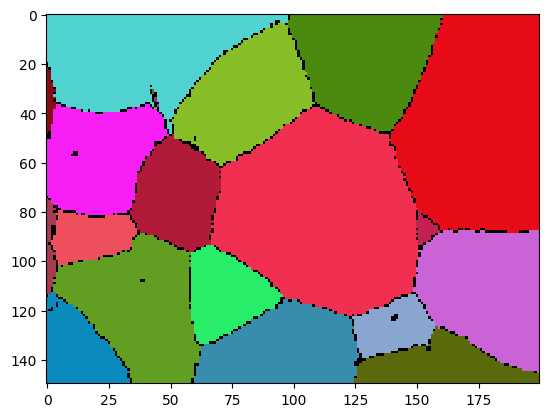

In [4]:
# on peut maintenant observe la cartographie EBSD coloree en fonction des differents grains identifies par segment_grains
rand_cmap = Microstructure.rand_cmap(first_is_black=True)
plt.imshow(scan.grain_ids.T, cmap=rand_cmap, interpolation='nearest')
plt.show()

In [5]:
# on peut verifier la symetrie du cristal, qui est bien hexagonale ici
sym = scan.phase_list[0].get_symmetry()
print(sym)

Symmetry.hexagonal


On peut également pointer deux pixels quelconques de la cartographie par leurs coordonnées, et le programme nous indique à quels grains ils appartiennent ainsi que la désorientation entre les deux :

In [6]:
from pymicro.crystal.microstructure import Orientation

g11, g12 = 125,20
g21, g22 = 175,50

print(scan.grain_ids[g11, g12])
o2 = Orientation.from_euler(np.degrees(scan.euler[g11, g12, :]))
print(scan.grain_ids[g21, g22])
o3 = Orientation.from_euler(np.degrees(scan.euler[g21, g22, :]))
mis_angle = np.degrees(o2.disorientation(o3, crystal_structure=sym)[0])
print('misorientation between grains', scan.grain_ids[g11, g12], 'and', scan.grain_ids[g21, g22] ,'is %.1f degrees' % mis_angle)

2
3
misorientation between grains 2 and 3 is 36.5 degrees
